In [1]:
# 데이터 불러오기
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state =42)

4422102/4422102 [==============================] - 0s 0us/step


# 합성곱 신경망 만들기

In [2]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding = 'same', input_shape=(28, 28, 1)))

필터 수 = 32개    
커널 크기 = 3 * 3  
활성화 함수 = 렐루, 세임패딩  
이미지 변경 (28, 28) -> (28, 28, 1)  


In [3]:
# 풀링층 추가
model.add(keras.layers.MaxPooling2D(2))   # 보통 가로세로값이 동일하기에, 2 만 적어도 (2,2) 로 알아듣는다.

필터가 32개이므로 깊이는 32가 된다.  
28, 28을 반으로 줄였으니 14, 14크기가 된다.  
즉, (14, 14, 32)가 될 것이다.

In [4]:
# 두번째 합성곱 - 플립층, 필터를 64개로 늘렸다.
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding = 'same'))
model.add(keras.layers.MaxPooling2D(2))

이제 (7, 7, 64)가 될 것이다.  

In [5]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

은닉층과 출력층 사이에 드롭아웃을 넣었다.  
이것은 과대적합을 막아줄 것이다.  
은닉층은 100개의 뉴런을 사용하고 활성화 함수로 렐루함수를 사용한다.  
패션MNIST 데이터셋은 클래스 10개를 분류하는 다중 분류 문제이므로 마지막 층의 활성화 함수는 소프트맥스를 사용한다.  


In [6]:
# 모델 구조를 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

이제 이 합성곱 신경망 모델로 각 층 파라미터 개수를 검증해보자  
plot_model()을 사용해 그림으로 표현 가능

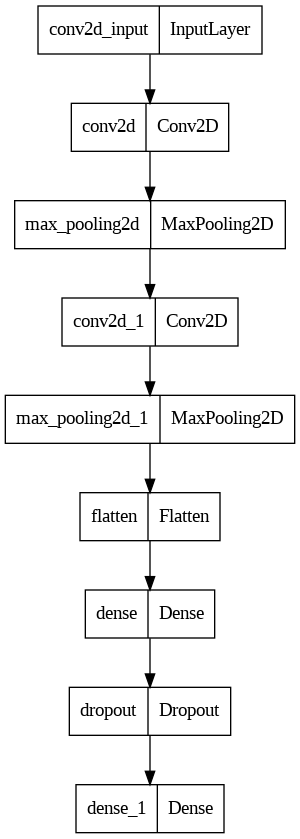

In [7]:
keras.utils.plot_model(model)

왼쪽에는 층의 이름, 오른쪽에는 클래스가 나타난다.  
더 많은 정보를 보려면 show_shapes를 사용하면 된다.

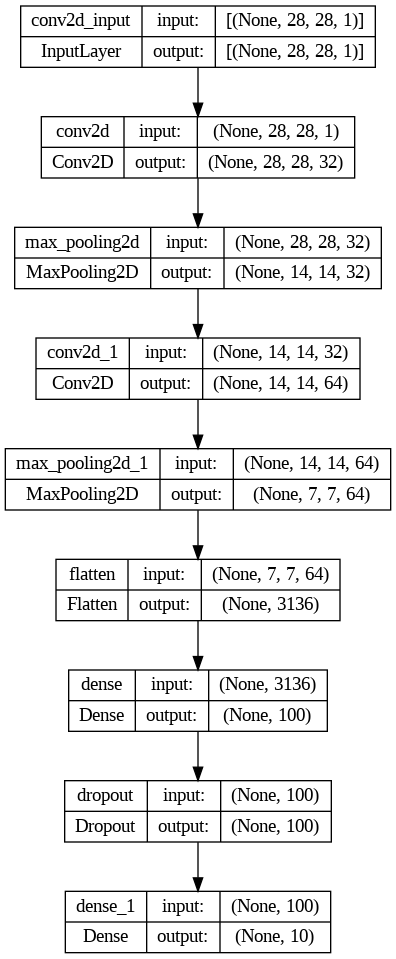

In [8]:
keras.utils.plot_model(model, show_shapes = True)

오른쪽에 input, output 상자에서 층으로 입력되는 크기와 출력되는 크기가 나타난다.

# 모델 컴파일과 훈련
Adam 옵티마이저를 사용하고 ModelCheckpoint 콜백과 조기종료 콜백을 함께 사용하자

In [9]:
model.compile(optimizer= 'adam', loss = 'sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs = 20, validation_data = (val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])


Epoch 1/20
1500/1500 [==============================] - 79s 52ms/step - loss: 0.5055 - accuracy: 0.8181 - val_loss: 0.3495 - val_accuracy: 0.8726
Epoch 2/20
1500/1500 [==============================] - 77s 51ms/step - loss: 0.3416 - accuracy: 0.8769 - val_loss: 0.2822 - val_accuracy: 0.8966
Epoch 3/20
1500/1500 [==============================] - 78s 52ms/step - loss: 0.2911 - accuracy: 0.8940 - val_loss: 0.2530 - val_accuracy: 0.9047
Epoch 4/20
1500/1500 [==============================] - 78s 52ms/step - loss: 0.2607 - accuracy: 0.9043 - val_loss: 0.2451 - val_accuracy: 0.9099
Epoch 5/20
1500/1500 [==============================] - 78s 52ms/step - loss: 0.2381 - accuracy: 0.9127 - val_loss: 0.2326 - val_accuracy: 0.9156
Epoch 6/20
1500/1500 [==============================] - 77s 51ms/step - loss: 0.2144 - accuracy: 0.9193 - val_loss: 0.2344 - val_accuracy: 0.9128
Epoch 7/20
1500/1500 [==============================] - 76s 51ms/step - loss: 0.1991 - accuracy: 0.9257 - val_loss: 0.2210 -

훈련세트의 정확도가 이전보다 훨씬 좋아졌다.  
손실그래프를 그려서 조기종료 여부를 확인해보자

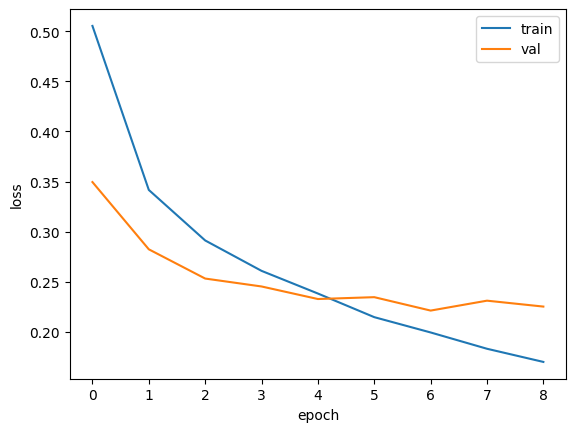

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

이 그래프를 기반으로, 8번째 에포크가 최적이라고 볼 수 있다.
  
이번엔 세트에 대한 성능 평가를 해본다.  

In [11]:
# 이번에는 세트에 대한 성능 평가
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 6s 17ms/step - loss: 0.2210 - accuracy: 0.9177


[0.22101370990276337, 0.9176666736602783]

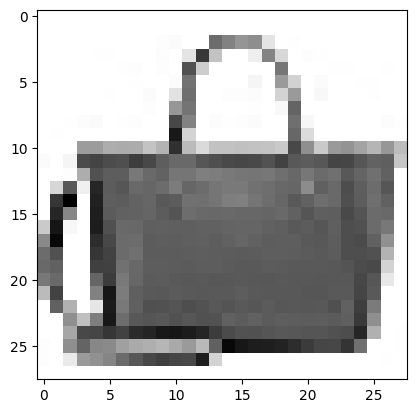

In [12]:
plt.imshow(val_scaled[0].reshape(28,28), cmap='gray_r')
plt.show()

핸드백 이미지다.  
모델은 이 이미지에 대해 어떤 예측을 만드는지 확인해보자  
10개의 클래스에 대한 예측 확률을 출력해보자

In [13]:
preds = model.predict(val_scaled[0:1])
print(preds)

1/1 [==============================] - 0s 111ms/step
[[4.9118560e-15 2.6388367e-20 2.5626903e-18 8.2331483e-17 6.9302071e-16
  1.2414991e-12 1.7235718e-16 3.3663720e-17 1.0000000e+00 3.4353564e-20]]


9번째 값만 1이고 나머지는 0에 한없이 가까운 숫자다.  
이를 그래프로 출력해보자

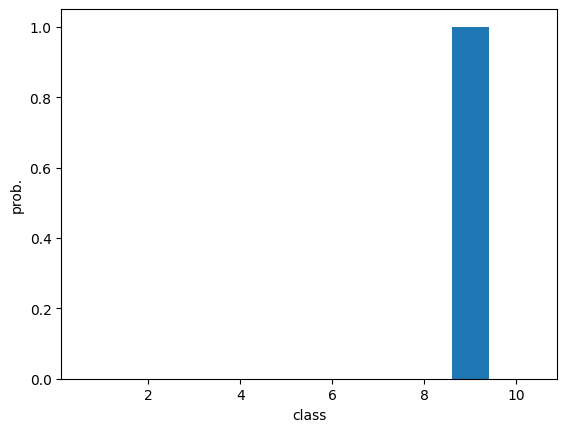

In [14]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

9번 클래스에 속한다고 아주 강하게 주장하고 있다.  
클래스를 만들어서 글자로 표현해보자  

In [15]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

클래스 리스트를 따라 레이블을 출력한다.  
preds 배열에서 가장 큰 인덱스를 찾아 classes 리스트의 인덱스로 사용하자  
여기서 보면, 9번은 가방으로 되어 있다.  

In [16]:
import numpy as np
print(classes[np.argmax(preds)])

가방


가방이라고 아주 잘 예측한 모습이다.  
이 모델을 실전에 투입했을 때 얻을 수 있는 예상 성능을 출력해보자

In [17]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

evaluate() 메서드로 테스트 세트에 대한 성능을 측정해보자

In [18]:
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 4s 13ms/step - loss: 0.2392 - accuracy: 0.9147


[0.23919811844825745, 0.9146999716758728]

약 91%의 성능을 기대할 수 있다.